# Credit card transaction

In [3]:
% matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Calculate list of id that does not excced the limit.

In [4]:
cc_info = pd.read_csv('cc_info.csv',index_col='credit_card')
cc_info.index = cc_info.index.astype(str)
transaction = pd.read_csv('transactions.csv',)
transaction['credit_card'] = transaction.credit_card.astype(str)

transaction.loc[:,'year_month'] = transaction.loc[:,'date'].str[:7]

agg = transaction.groupby(['credit_card','year_month']).sum().transaction_dollar_amount

max_month = agg.groupby([agg.index.get_level_values(0)]).max().to_frame()
max_month.columns = ['max_amount']

cc_info = cc_info.merge(max_month, right_index=True, left_index=True)

In [5]:
id_list = list(cc_info[cc_info.max_amount < cc_info.credit_card_limit].index)
print('The number of id is ' + str(len(id_list)))

The number of id is 862


In [6]:
with open('list.txt','w') as file:
    for id in id_list:
        file.write(id + '\n')

## A function that will generate a list of users who went above their credit card monthly limit.

In [7]:
class alert(object):
    def __init__(self):
        self.cc_info = pd.read_csv('cc_info.csv',index_col='credit_card')
        self.cc_info.index = self.cc_info.index.astype(str)
        self.transaction = pd.read_csv('transactions.csv',)
        self.transaction['credit_card'] = self.transaction.credit_card.astype(str)
        self.transaction.loc[:,'year_month'] = self.transaction.loc[:,'date'].str[:7]
        self.transaction.loc[:,'day'] = self.transaction.loc[:,'date'].str[8:10]
    
    def find(self, year, month, day):
        year_month = format(year,'04d') + '-' + format(month, '02d')
        day = format(day, '02d')
        transactionSoFar = self.transaction.loc[(self.transaction.year_month==year_month)
                                            &((self.transaction.day.astype(int)) < int(day))]
        spentSoFar = transactionSoFar.groupby(['credit_card'])\
                                        .sum()\
                                        .transaction_dollar_amount\
                                        .to_frame()
        spentSoFar.columns=['spentSoFar']
        cc_info = self.cc_info.merge(spentSoFar, right_index=True, left_index=True)
        cc_info = cc_info[cc_info.spentSoFar<cc_info.credit_card_limit]
        
        transactionToday = self.transaction.loc[(self.transaction.year_month==year_month)
                                            &((self.transaction.day.astype(int)) == int(day))]
        spentToday = transactionToday.groupby(['credit_card'])\
                                        .sum()\
                                        .transaction_dollar_amount\
                                        .to_frame()
        spentToday.columns = ['spentToday']
        cc_info = cc_info.merge(spentToday, left_index = True, right_index = True)
        OverSpentToday = cc_info[cc_info.spentSoFar + cc_info.spentToday >=
                                 cc_info.credit_card_limit]
        alertList = list(OverSpentToday.index)
        print(alertList)

In [8]:
predictor = alert()

predictor.find(2015, 10, 30)

['3546693056773873', '9727202337611852']


## Return all suspicious transactions.

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn import svm

In [10]:
cc_info = pd.read_csv('cc_info.csv',index_col='credit_card')
cc_info.index = cc_info.index.astype(str)
transaction = pd.read_csv('transactions.csv',)
transaction['credit_card'] = transaction.credit_card.astype(str)

creditCardList = transaction.credit_card.unique()

singleCard = transaction[transaction.credit_card==creditCardList[20]]

### One class SVM

In [11]:
clf = svm.OneClassSVM(nu=0.01, kernel='poly',degree=3, gamma='auto')
clf.fit(singleCard.loc[:,('Lat','Long')])

predictedLabel = clf.predict(singleCard.loc[:,('Lat','Long')])
predictedcolor = list(map(lambda x: 'b' if x==1 else 'r', predictedLabel))

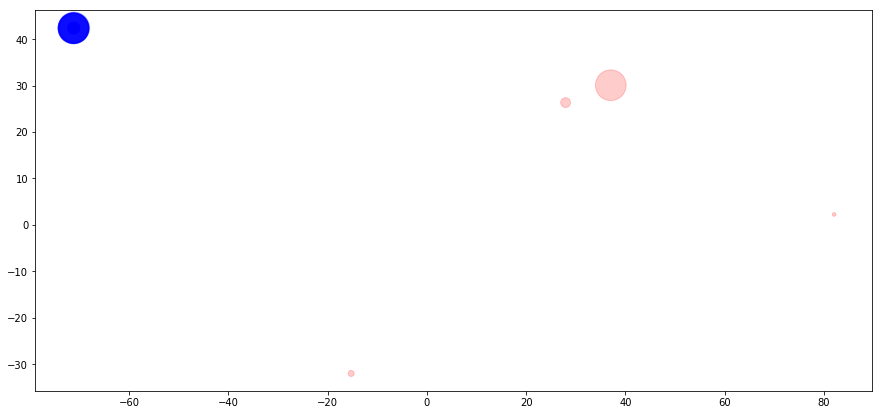

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(singleCard.Long,singleCard.Lat,s=singleCard.transaction_dollar_amount,
            alpha=0.2, c=predictedcolor)

(42.3, 42.6)

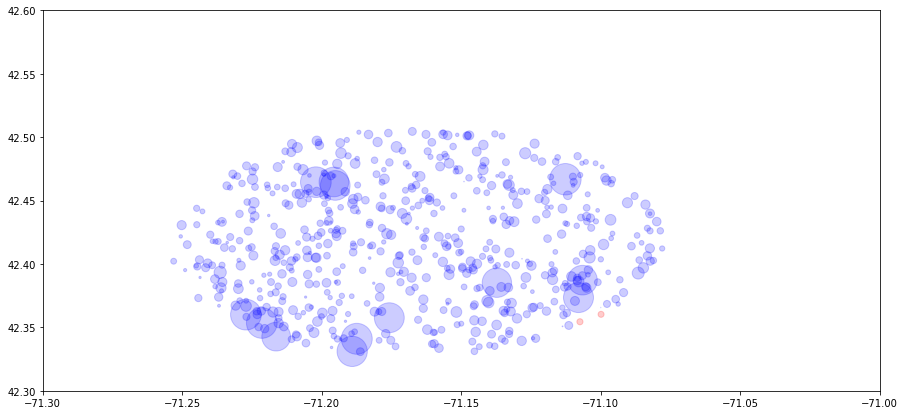

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(singleCard.Long,singleCard.Lat,s=singleCard.transaction_dollar_amount,
            alpha=0.2, c=predictedcolor)
ax.set_xlim(-71.3,-71)
ax.set_ylim(42.3,42.6)

In [14]:
singleCard[predictedLabel==-1]

,credit_card,date,transaction_dollar_amount,Long,Lat
6245,1175962294549313,2015-08-22 21:09:47,96.81,27.956220,26.352738
6344,1175962294549313,2015-09-25 16:35:50,941.42,37.066598,30.093280
6397,1175962294549313,2015-08-23 02:59:12,36.20,-71.099913,42.360291
6622,1175962294549313,2015-09-05 01:47:28,36.20,-15.249559,-32.007490
6684,1175962294549313,2015-09-18 20:38:41,13.36,82.072341,2.248183
6691,1175962294549313,2015-10-11 03:03:36,37.88,-71.107482,42.354438


### DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

In [16]:
clf = DBSCAN(eps=0.1, min_samples=2)
clf.fit(singleCard.loc[:,('Lat','Long')])

predictedLabel = clf.labels_
predictedcolor = list(map(lambda x: 'b' if x==0 else 'r', predictedLabel))

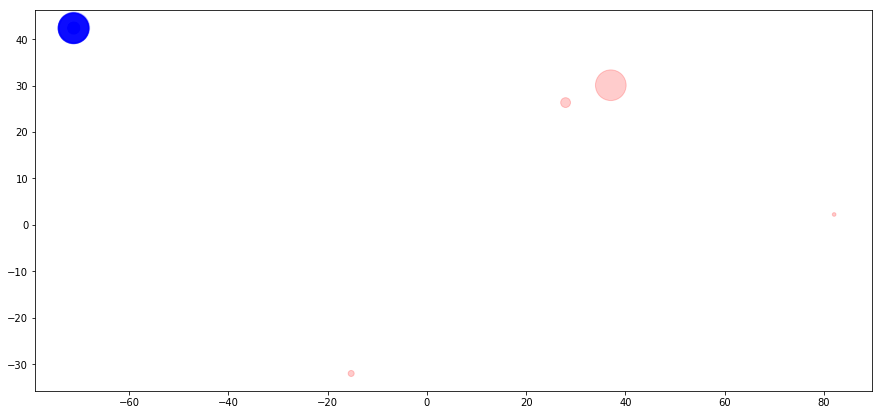

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(singleCard.Long,singleCard.Lat,s=singleCard.transaction_dollar_amount,
            alpha=0.2, c=predictedcolor)

(42.3, 42.6)

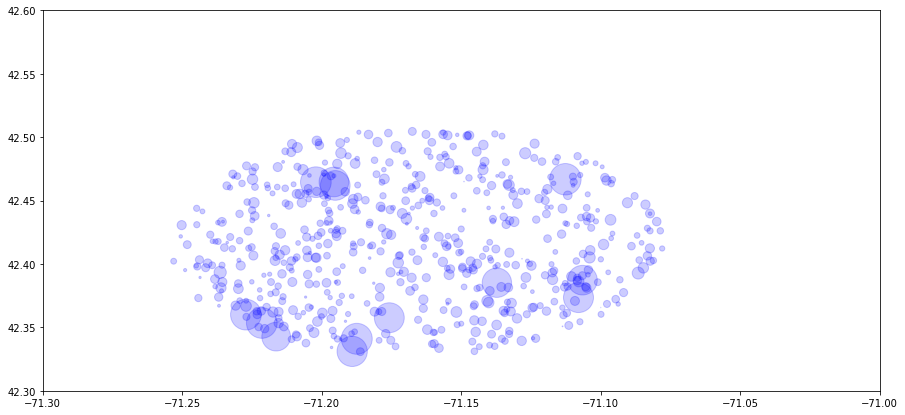

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(singleCard.Long,singleCard.Lat,s=singleCard.transaction_dollar_amount,
            alpha=0.2, c=predictedcolor)
ax.set_xlim(-71.3,-71)
ax.set_ylim(42.3,42.6)

In [19]:
singleCard[predictedLabel==-1]

,credit_card,date,transaction_dollar_amount,Long,Lat
6245,1175962294549313,2015-08-22 21:09:47,96.81,27.956220,26.352738
6344,1175962294549313,2015-09-25 16:35:50,941.42,37.066598,30.093280
6622,1175962294549313,2015-09-05 01:47:28,36.20,-15.249559,-32.007490
6684,1175962294549313,2015-09-18 20:38:41,13.36,82.072341,2.248183


### Actual prediction using DBSCAN

In [20]:
suspeciousDf = pd.DataFrame(columns=transaction.columns)
clf = DBSCAN(eps=0.1, min_samples=2)
for creditID in creditCardList:
    singleCard = transaction[transaction.credit_card==creditID]
    clf.fit(singleCard.loc[:,('Lat','Long')])

    predictedLabel = clf.labels_
    suspeciousDf = pd.concat([suspeciousDf, singleCard[predictedLabel==-1]])

In [21]:
suspeciousDf

,credit_card,date,transaction_dollar_amount,Long,Lat
8,1003715054175576,2015-09-17 19:20:37,95.20,-2.833179,34.745015
14,1003715054175576,2015-09-18 21:44:21,146.75,69.475216,25.125749
113,1003715054175576,2015-09-08 16:43:42,99.27,34.429275,24.659874
128,1003715054175576,2015-10-25 00:11:25,87.77,102.032338,-32.343578
141,1003715054175576,2015-09-25 20:51:42,53.31,-7.373733,-11.785999
259,1003715054175576,2015-10-29 23:47:59,103.11,8.360145,36.188123
306,1013870087888817,2015-10-06 00:34:58,40.52,110.386103,52.238635
484,1013870087888817,2015-08-07 17:47:29,66.33,31.083820,0.500182
495,1013870087888817,2015-10-15 18:20:18,109.28,15.466472,51.695983
512,1013870087888817,2015-08-08 19:19:18,72.65,86.661892,32.787973


In [23]:
suspeciousDf.to_csv('suspeciousTransaction.csv')